# State Construction Task

In [1]:
from datetime import datetime
from time import time
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be und

In [2]:
dim = 4

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [3]:
def equidistributed_points(dim, dist):
    with np.errstate(divide='ignore'):
        if np.isnan(dist):
            dist = 4 * np.pi
        if dim == 2:
            phis = np.arange(0, 2 * np.pi, dist)
            return np.vstack([np.cos(phis), np.sin(phis)])
        else:
            slices = []
            for phi in np.arange(0, np.pi, dist):
                proj_points = equidistributed_points(dim - 1, dist / np.sin(phi))
                points = np.vstack([np.full((1, proj_points.shape[1]), np.cos(phi)), np.sin(phi) * proj_points])
                slices.append(points)
            return np.hstack(slices)

## solve using Tensorflow

parametric hamiltonian generator with `tf.Variable`

and a solver

In [4]:
class GradientNorm(tf.train.Optimizer):
    def __init__(self, learning_rate=0.1, use_locking=False, name="GradientNorm"):
        super().__init__(use_locking, name)
        self._lr = learning_rate
        
        # Tensor versions of the constructor arguments, created in _prepare().
        self._lr_t = None

    def _prepare(self):
        self._lr_t = tf.convert_to_tensor(self._lr, name="learning_rate")

    def _apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        var_update = tf.assign_sub(var, lr_t * tf.linalg.l2_normalize(grad, axis=1))
        
        return tf.group(*[var_update])

    def _apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

In [5]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def batch_solve_tensorflow(dim, h_generator, source, targets, batch_size, depth):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = -tf.reduce_sum(fidelities)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        for t in tqdm(targets):
            init_op = tf.global_variables_initializer()
            session.run(init_op)
            for i in range(depth): # todo, improve stop
                session.run(optimize_op, feed_dict={target: t})

            yield session.run(fidelities, feed_dict={target: t})

## solve using NumPy

In [6]:
angle = 0.3
batch_size = 1024

source = np.array([1] + [0] * (dim - 1))
map_points = equidistributed_points(2 * dim, angle).T
targets = map_points[:, :dim] + 1j * map_points[:, dim:]
targets_count = targets.shape[0]
print('count: %d' % targets_count)

count: 162820


In [9]:
STOP = 0.99
duration = 30 * 60 # 30 minutes
reminded_targets = targets
fidelities = np.zeros(())
start = time()
depth = 100
while reminded_targets.shape[0] > 0 and (time() - start) < duration:
    batch_size = max(min(1024, reminded_targets.shape[0]), 2)
    ts = reminded_targets
    if reminded_targets.shape[0] % batch_size:
        ts = np.vstack([ts, np.zeros((batch_size - (reminded_targets.shape[0] % batch_size), dim))])
    ts = np.split(ts, ts.shape[0] // batch_size)
    
    res = list(batch_solve_tensorflow(dim, h_generator, source, ts, batch_size, depth))
    res = np.vstack(res)
    res = np.squeeze(res)
    res = res[:reminded_targets.shape[0]]
    fidelities = np.append(fidelities, res[res > STOP])
    
    reminded_targets = reminded_targets[res < STOP]
    depth = int(depth * 1.2)
    print('remainings: %d, min: %f, depth: %d' % (reminded_targets.shape[0], res.min(), depth))



remainings: 67166, min: 0.213195, depth: 120



remainings: 38576, min: 0.332268, depth: 144



remainings: 24725, min: 0.461279, depth: 172



remainings: 16209, min: 0.496424, depth: 206



remainings: 10739, min: 0.520371, depth: 247



remainings: 6843, min: 0.581057, depth: 296



remainings: 4289, min: 0.624704, depth: 355



remainings: 2625, min: 0.703982, depth: 426



remainings: 1620, min: 0.701357, depth: 511



remainings: 1056, min: 0.661060, depth: 613



remainings: 739, min: 0.709871, depth: 735



remainings: 551, min: 0.738898, depth: 882



remainings: 441, min: 0.792416, depth: 1058



remainings: 364, min: 0.808003, depth: 1269



remainings: 292, min: 0.926946, depth: 1522



remainings: 261, min: 0.880410, depth: 1826



remainings: 229, min: 0.896120, depth: 2191



remainings: 206, min: 0.936002, depth: 2629



remainings: 196, min: 0.912116, depth: 3154



remainings: 181, min: 0.875667, depth: 3784



remainings: 172, min: 0.926258, depth: 4540



remainings: 162, min: 0.918713, depth: 5448



remainings: 154, min: 0.935525, depth: 6537



remainings: 147, min: 0.914835, depth: 7844



remainings: 145, min: 0.931182, depth: 9412



remainings: 141, min: 0.929564, depth: 11294



remainings: 135, min: 0.913382, depth: 13552



remainings: 134, min: 0.929564, depth: 16262



remainings: 130, min: 0.914835, depth: 19514


KeyboardInterrupt: 

In [8]:
f_min = fidelities[1:].min()
d = np.cos(angle)
MGF = (np.sqrt(d * f_min) - np.sqrt((1 - d) * (1 - f_min))) ** 2

print('d: ', d)
print('minimum fidelity: ', f_min)
print('average fidelity: ', fidelities[1:].mean())
print('MGF: ', MGF)
print('count: ', targets_count)

d:  0.955336489125606
minimum fidelity:  0.950003857959084
average fidelity:  0.99003668751044
MGF:  0.8197704890069187
count:  162820


In [40]:
worst = targets[fidelities.argmin(),:]
worst = np.repeat(np.expand_dims(worst, axis=0), 1024, axis=0)
worst_fidelity = list(batch_solve_tensorflow(dim, h_generator, source, [worst], 1024))[0]

worst state:  [ 0.69670671-0.23721988j -0.07305283+0.08046582j  0.31025008+0.18170155j
  0.20579312-0.52430302j]


(array([ 20.,  61., 102.,  28.,  24.,  24.,  28.,  53., 156., 528.]),
 array([0.65473942, 0.68898983, 0.72324024, 0.75749065, 0.79174106,
        0.82599147, 0.86024189, 0.8944923 , 0.92874271, 0.96299312,
        0.99724353]),
 <a list of 10 Patch objects>)

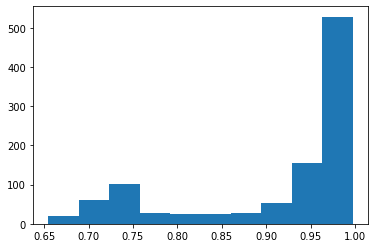

In [41]:
print('worst state: ', targets[fidelities.argmin(),:])
plt.hist(np.squeeze(np.vstack(worst_fidelity)))

implement heisenberg model

In [94]:
basis = [0b100, 0b010, 0b001]

# external field
diag = lambda i : np.diag([(b >> i) & 1 for b in basis])

# coupling
def nondiag(i):
    [[if (a ^ b) >> for b in basis] for a in basis]
            

In [ ]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

In [85]:
def bgfs_optimization(dim, source, targets, batch_size):
    places = tf.constant(np.stack([sp.coo_matrix(
            ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray() 
              for i in range(dim - 1)] + 
             [sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
              for i in range(dim)]), dtype='complex128')

    source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])

    for target in targets:
        target = tf.tile(tf.expand_dims(tf.constant([0] * (dim - 1) + [1], dtype='complex128'), axis=0), [batch_size, 1])
        def fidelity(params):
            h = tf.tensordot(tf.cast(params, 'complex128'), places, axes=[1, 0])

            u = tf.linalg.expm(1j * h)
            estimated_target = tf.matmul(u, tf.expand_dims(source, 2))

            target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
            fidelities = tf.abs(target_dot)
            loss = -tf.reduce_sum(fidelities)
            print(tf.gradients(loss, params)[0].shape)
            return loss, tf.gradients(loss, params)[0]

        start = tf.constant(np.random.randn(batch_size, 2 * dim - 1))
        print(start.shape, target.shape, source.shape)
        results = tfp.optimizer.bfgs_minimize(fidelity, initial_position=start, tolerance=1e-5)

        
        

In [86]:
bgfs_optimization(dim, source, [ts[0]], 4)

(4, 7) (4, 4) (4, 4)
(4, 7)
(4, 7)
(4, 7)


ValueError: Shapes must be equal rank, but are 0 and 1 for 'minimize_14/while/hager_zhang/Select_1' (op: 'Select') with input shapes: [4], [], [].